Using MPS (Metal Performance Shaders) - Apple Silicon GPU acceleration.

----------------
Interactive Image Captioning System.
----------------

This system provides two main options:
1. Train a new image captioning model from scratch
2. Use an existing trained model to generate captions

----------------
Main Menu
----------------
1. Train new model (requires Flickr8k dataset)
2. Generate captions using existing model
3. Exit

----------------
Option 2: Generate captions for new images
----------------
Loading existing model...
Loading model from caption_model.pth...
Model loaded successfully.

----------------
Caption Generation Options:
----------------
1. Caption a single image
2. Back to main menu
Generated Caption: a man in a blue shirt is walking on a road


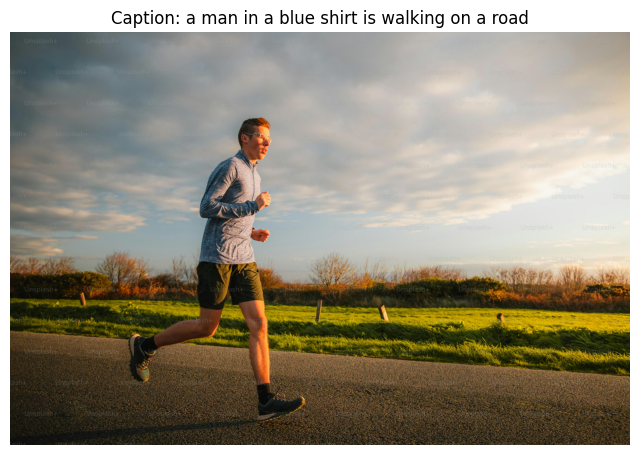


----------------
Caption Generation Options:
----------------
1. Caption a single image
2. Back to main menu
Generated Caption: a race car is driving down a track


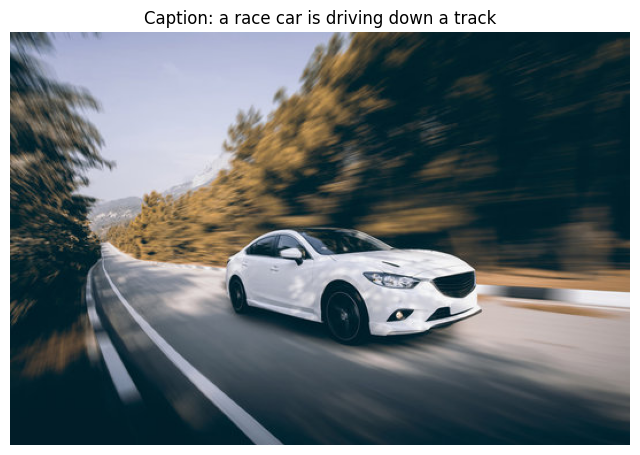


----------------
Caption Generation Options:
----------------
1. Caption a single image
2. Back to main menu
Generated Caption: a man rides a bike on a road


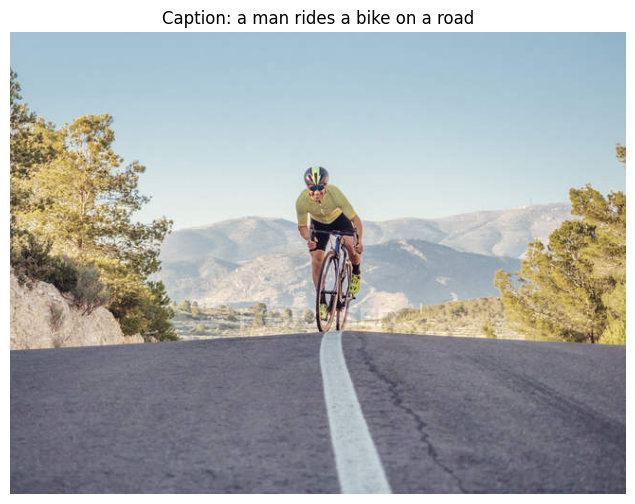


----------------
Caption Generation Options:
----------------
1. Caption a single image
2. Back to main menu

----------------
Main Menu
----------------
1. Train new model (requires Flickr8k dataset)
2. Generate captions using existing model
3. Exit
The system ends.


In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import re
import sys
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt', quiet=True)
if __name__ == '__main__':
    import multiprocessing
    multiprocessing.set_start_method('spawn', force=True)
def set_random_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_random_seeds(42)
def get_optimal_device():
    if torch.backends.mps.is_available():
        device = torch.device('mps')
        print(f"Using MPS (Metal Performance Shaders) - Apple Silicon GPU acceleration.")
    elif torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"Using CUDA GPU.")
    else:
        device = torch.device('cpu')
        print("Using CPU.")
    return device
device = get_optimal_device()
class DataPreprocessor:
    def __init__(self, text_dir, image_dir):
        self.text_dir = text_dir
        self.image_dir = image_dir
        self.vocab_to_idx = {}
        self.idx_to_vocab = {}
        self.vocab_size = 0
    def load_captions(self):
        caption_file = os.path.join(self.text_dir, 'Flickr8k.token.txt')
        captions = {}
        with open(caption_file, 'r', encoding='utf-8', errors='ignore') as f:
            for line in f:
                line = line.strip()
                if line:
                    parts = line.split('\t')
                    if len(parts) >= 2:
                        img_info = parts[0]
                        caption = '\t'.join(parts[1:])
                        img_name = img_info.split('#')[0]
                        if img_name not in captions:
                            captions[img_name] = []
                        captions[img_name].append(caption.lower())
        print(f"Loaded captions for {len(captions)} images.")
        return captions
    def clean_caption(self, caption):
        caption = re.sub(r'[^\w\s\-\.\,\!\?]', '', caption)
        caption = re.sub(r'\s+', ' ', caption).strip()
        words = caption.split()
        filtered_words = []
        for word in words:
            if len(word) >= 2 or word in ['a', 'i']:
                if not word.isdigit() or len(word) <= 2:
                    filtered_words.append(word)
        if len(filtered_words) < 3 or len(filtered_words) > 20:
            return None
        caption = ' '.join(filtered_words)
        return f"<start> {caption} <end>"
    def build_vocabulary(self, captions, min_freq=2):
        word_counts = Counter()
        valid_captions = 0
        for img_captions in captions.values():
            for caption in img_captions:
                clean_cap = self.clean_caption(caption)
                if clean_cap:
                    words = clean_cap.split()
                    word_counts.update(words)
                    valid_captions += 1
        vocab_items = [(word, count) for word, count in word_counts.items() if count >= min_freq]
        vocab_items.sort(key=lambda x: x[1], reverse=True)
        vocab = ['<pad>', '<unk>', '<start>', '<end>'] + [word for word, _ in vocab_items if word not in ['<pad>', '<unk>', '<start>', '<end>']]
        self.vocab_to_idx = {word: idx for idx, word in enumerate(vocab)}
        self.idx_to_vocab = {idx: word for word, idx in self.vocab_to_idx.items()}
        self.vocab_size = len(vocab)
        print(f"Most common words: {[word for word, _ in vocab_items[:10]]}")
        return self.vocab_to_idx, self.idx_to_vocab
    def caption_to_indices(self, caption):
        clean_cap = self.clean_caption(caption)
        if not clean_cap:
            return None
        words = clean_cap.split()
        indices = []
        for word in words:
            idx = self.vocab_to_idx.get(word, self.vocab_to_idx['<unk>'])
            indices.append(idx)
        return indices
    def prepare_dataset(self):
        captions = self.load_captions()
        self.build_vocabulary(captions)
        train_file = os.path.join(self.text_dir, 'Flickr_8k.trainImages.txt')
        with open(train_file, 'r') as f:
            train_images = [line.strip() for line in f]
        train_data = []
        caption_length_stats = []
        for img_name in train_images:
            if img_name in captions:
                img_path = os.path.join(self.image_dir, img_name)
                if os.path.exists(img_path):
                    valid_captions = []
                    for caption in captions[img_name]:
                        caption_indices = self.caption_to_indices(caption)
                        if caption_indices and len(caption_indices) >= 4:
                            valid_captions.append({
                                'indices': caption_indices,
                                'text': caption
                            })
                            caption_length_stats.append(len(caption_indices))
                    for cap_data in valid_captions:
                        train_data.append({
                            'image_path': img_path,
                            'caption_indices': cap_data['indices'],
                            'caption_text': cap_data['text']
                        })
        avg_length = np.mean(caption_length_stats) if caption_length_stats else 0
        print(f"Average caption length: {avg_length:.2f} words")
        return train_data
    def load_vocabulary(self, vocab_to_idx, idx_to_vocab, vocab_size):
        self.vocab_to_idx = vocab_to_idx
        self.idx_to_vocab = idx_to_vocab
        self.vocab_size = vocab_size
class FeatureExtractor:
    def __init__(self):
        self.model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.model = nn.Sequential(*list(self.model.children())[:-2])
        self.model.eval()
        self.model.to(device)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((8, 8))
        self.train_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomCrop((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
            transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.3),
            transforms.RandomGrayscale(p=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.RandomErasing(p=0.1, scale=(0.02, 0.15), ratio=(0.3, 3.3))
        ])
        self.eval_transforms = [
            transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]),
            transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.CenterCrop((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        ]
    def extract_features(self, image_path, training=False, use_tta=False):
        try:
            image = Image.open(image_path).convert('RGB')
            if training:
                image_tensor = self.train_transform(image).unsqueeze(0).to(device)
                with torch.no_grad():
                    features = self.model(image_tensor)
                    if device.type == 'mps':
                        features = features.cpu()
                    features = self.adaptive_pool(features)
                    features = features.flatten(2).permute(0, 2, 1)
                    features = features.squeeze(0).cpu().numpy()
                return features
            else:
                if use_tta:
                    all_features = []
                    for transform in self.eval_transforms:
                        image_tensor = transform(image).unsqueeze(0).to(device)
                        with torch.no_grad():
                            features = self.model(image_tensor)
                            if device.type == 'mps':
                                features = features.cpu()
                            features = self.adaptive_pool(features)
                            features = features.flatten(2).permute(0, 2, 1)
                            features = features.squeeze(0).cpu().numpy()
                            all_features.append(features)
                    return np.mean(all_features, axis=0)
                else:
                    image_tensor = self.eval_transforms[0](image).unsqueeze(0).to(device)
                    with torch.no_grad():
                        features = self.model(image_tensor)
                        if device.type == 'mps':
                            features = features.cpu()
                        features = self.adaptive_pool(features)
                        features = features.flatten(2).permute(0, 2, 1)
                        features = features.squeeze(0).cpu().numpy()
                    return features
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            return None
    def extract_all_features(self, data, features_file='image_features.pkl'):
        if os.path.exists(features_file):
            print("Loading existing features...")
            with open(features_file, 'rb') as f:
                return pickle.load(f)
        features_dict = {}
        unique_images = list(set([item['image_path'] for item in data]))
        failed_images = []
        for i, img_path in enumerate(unique_images):
            if i % 100 == 0:
                print(f"Processing: {i}/{len(unique_images)}")
            features = self.extract_features(img_path, training=False, use_tta=True)
            if features is not None:
                features_dict[img_path] = features
            else:
                failed_images.append(img_path)
        if failed_images:
            print(f"Failed to process {len(failed_images)} images:")
            for img in failed_images:
                print(f" - {img}")
        with open(features_file, 'wb') as f:
            pickle.dump(features_dict, f)
        print(f"Extracted features.")
        print(f"Features saved to {features_file}.")
        return features_dict
class CaptionDataset(Dataset):
    def __init__(self, data, features_dict, max_length=22):
        self.data = []
        self.max_length = max_length
        for item in data:
            if item['image_path'] in features_dict:
                caption_indices = item['caption_indices']
                if len(caption_indices) <= max_length:
                    self.data.append({
                        'features': features_dict[item['image_path']],
                        'caption_indices': caption_indices,
                        'caption_text': item['caption_text']
                    })
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            'features': torch.FloatTensor(item['features']),
            'caption_indices': torch.LongTensor(item['caption_indices']),
            'caption_text': item['caption_text']
        }
def collate_fn(batch):
    features = torch.stack([item['features'] for item in batch])
    captions = [item['caption_indices'] for item in batch]
    caption_texts = [item['caption_text'] for item in batch]
    captions_padded = pad_sequence(captions, batch_first=True, padding_value=0)
    return {
        'features': features,
        'captions': captions_padded,
        'caption_texts': caption_texts
    }
class TransformerCaptionGenerator(nn.Module):
    def __init__(self, feature_dim=2048, spatial_dim=64, vocab_size=5000, embed_dim=512, 
                 num_heads=8, num_layers=6, max_length=22, dropout=0.1):
        super(TransformerCaptionGenerator, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.max_length = max_length
        self.spatial_dim = spatial_dim
        self.spatial_feature_proj = nn.Sequential(
            nn.Linear(feature_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, embed_dim),
            nn.LayerNorm(embed_dim)
        )
        self.spatial_pos_encoding = nn.Parameter(torch.randn(spatial_dim, embed_dim) * 0.02)
        self.word_embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_encoding = nn.Parameter(torch.randn(max_length, embed_dim) * 0.02)
        self.cross_attention = nn.MultiheadAttention(
            embed_dim, num_heads, dropout=dropout, batch_first=True
        )
        self.cross_attention_2 = nn.MultiheadAttention(
            embed_dim, num_heads, dropout=dropout, batch_first=True
        )
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.output_projection = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(embed_dim, vocab_size)
        )
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embed_dim)
        self._init_weights()
    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight, gain=1.0)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0, std=0.02)
                if hasattr(module, 'padding_idx') and module.padding_idx is not None:
                    module.weight.data[module.padding_idx].fill_(0)
            elif isinstance(module, nn.LayerNorm):
                nn.init.ones_(module.weight)
                nn.init.zeros_(module.bias)
    def forward(self, image_features, captions=None, max_length=None, generate_mode=False):
        batch_size = image_features.size(0)
        image_features = image_features.float()
        img_features = self.spatial_feature_proj(image_features)
        img_features = img_features + self.spatial_pos_encoding.unsqueeze(0)
        img_features = self.layer_norm(img_features)
        use_teacher_forcing = (captions is not None) and not generate_mode
        if use_teacher_forcing:
            seq_length = captions.size(1)
            captions = captions.long()
            word_embeds = self.word_embedding(captions)
            pos_enc = self.pos_encoding[:seq_length].unsqueeze(0).expand(batch_size, -1, -1)
            word_embeds = word_embeds + pos_enc
            word_embeds = self.dropout(word_embeds)
            attended_features, _ = self.cross_attention(
                word_embeds, img_features, img_features
            )
            word_embeds = word_embeds + attended_features
            word_embeds = self.layer_norm(word_embeds)
            attended_features_2, _ = self.cross_attention_2(
                word_embeds, img_features, img_features
            )
            word_embeds = word_embeds + attended_features_2 * 0.5
            word_embeds = self.layer_norm(word_embeds)
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(image_features.device)
            output = self.transformer_decoder(
                tgt=word_embeds,
                memory=img_features,
                tgt_mask=tgt_mask
            )
            logits = self.output_projection(output)
            return logits.float()
        else:
            if max_length is None:
                max_length = self.max_length
            start_token_idx = getattr(self, 'start_token_idx', 2)
            generated = torch.full((batch_size, 1), start_token_idx, dtype=torch.long, device=image_features.device)
            for step in range(max_length - 1):
                word_embeds = self.word_embedding(generated)
                seq_length = word_embeds.size(1)
                pos_enc = self.pos_encoding[:seq_length].unsqueeze(0).expand(batch_size, -1, -1)
                word_embeds = word_embeds + pos_enc
                word_embeds = self.dropout(word_embeds)
                attended_features, _ = self.cross_attention(
                    word_embeds, img_features, img_features
                )
                word_embeds = word_embeds + attended_features
                word_embeds = self.layer_norm(word_embeds)
                attended_features_2, _ = self.cross_attention_2(
                    word_embeds, img_features, img_features
                )
                word_embeds = word_embeds + attended_features_2 * 0.5
                word_embeds = self.layer_norm(word_embeds)
                tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(image_features.device)
                output = self.transformer_decoder(
                    tgt=word_embeds,
                    memory=img_features,
                    tgt_mask=tgt_mask
                )
                logits = self.output_projection(output)
                temperature = 0.9
                next_word_logits = logits[:, -1:, :] / temperature
                sorted_logits, sorted_indices = torch.sort(next_word_logits, descending=True, dim=-1)
                cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > 0.9
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0
                sorted_logits[sorted_indices_to_remove] = float('-inf')
                probs = torch.softmax(sorted_logits, dim=-1)
                next_word_sorted = torch.multinomial(probs.squeeze(1), 1)
                next_word = torch.gather(sorted_indices.squeeze(1), 1, next_word_sorted)
                generated = torch.cat([generated, next_word], dim=1)
                end_token_idx = getattr(self, 'end_token_idx', 3)
                if (next_word == end_token_idx).all():
                    break
            return generated
    def beam_search_generate(self, features, idx_to_vocab, max_length, num_beams):
        vocab_size = len(idx_to_vocab)
        start_token = self.start_token_idx if hasattr(self, 'start_token_idx') else 2
        end_token = self.end_token_idx if hasattr(self, 'end_token_idx') else 3
        batch_size = features.size(0)
        assert batch_size == 1, "Beam search currently supports batch_size=1"
        with torch.no_grad():
            img_features = self.spatial_feature_proj(features)
            img_features = img_features + self.spatial_pos_encoding.unsqueeze(0)
            img_features = self.layer_norm(img_features)
        beams = [([start_token], 0.0)]
        completed_beams = []
        for step in range(max_length - 1):
            candidates = []
            for seq, score in beams:
                if seq[-1] == end_token:
                    completed_beams.append((seq, score))
                    continue
                seq_tensor = torch.tensor([seq], dtype=torch.long, device=features.device)
                with torch.no_grad():
                    word_embeds = self.word_embedding(seq_tensor)
                    seq_length = word_embeds.size(1)
                    pos_enc = self.pos_encoding[:seq_length].unsqueeze(0)
                    word_embeds = word_embeds + pos_enc
                    word_embeds = self.dropout(word_embeds)
                    attended_features, _ = self.cross_attention(
                        word_embeds, img_features, img_features
                    )
                    word_embeds = word_embeds + attended_features
                    word_embeds = self.layer_norm(word_embeds)
                    attended_features_2, _ = self.cross_attention_2(
                        word_embeds, img_features, img_features
                    )
                    word_embeds = word_embeds + attended_features_2 * 0.5
                    word_embeds = self.layer_norm(word_embeds)
                    tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(features.device)
                    output = self.transformer_decoder(
                        tgt=word_embeds,
                        memory=img_features,
                        tgt_mask=tgt_mask
                    )
                    logits = self.output_projection(output)
                    logits = logits[:, -1, :] / 0.9
                    probs = torch.softmax(logits, dim=-1).squeeze(0)
                    top_probs, top_indices = probs.topk(num_beams)
                    for prob, idx in zip(top_probs.cpu().numpy(), top_indices.cpu().numpy()):
                        new_seq = seq + [idx]
                        new_score = score - math.log(prob + 1e-10)
                        candidates.append((new_seq, new_score))
            candidates.sort(key=lambda x: x[1])
            beams = candidates[:num_beams]
            if not beams:
                break
        completed_beams.extend(beams)
        completed_beams.sort(key=lambda x: x[1])
        best_seq, _ = completed_beams[0]
        return best_seq
def load_model_if_exists(model_path='caption_model.pth'):
    if os.path.exists(model_path):
        print(f"Loading model from {model_path}...")
        checkpoint = torch.load(model_path, map_location=device)
        vocab_to_idx = checkpoint['vocab_to_idx']
        idx_to_vocab = checkpoint['idx_to_vocab']
        vocab_size = checkpoint['vocab_size']
        model = TransformerCaptionGenerator(
            feature_dim=2048,
            spatial_dim=64,
            vocab_size=vocab_size,
            embed_dim=512,
            num_heads=8,
            num_layers=6,
            dropout=0.1
        ).to(device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.start_token_idx = vocab_to_idx.get('<start>', 2)
        model.end_token_idx = vocab_to_idx.get('<end>', 3)
        print("Model loaded successfully.")
        return model, vocab_to_idx, idx_to_vocab, vocab_size
    else:
        print(f"No existing model found at '{model_path}'.")
        return None, None, None, None
def save_model(model, vocab_to_idx, idx_to_vocab, vocab_size, optimizer, epoch, train_losses, val_losses, model_path='caption_model.pth'):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict() if optimizer else None,
        'vocab_to_idx': vocab_to_idx,
        'idx_to_vocab': idx_to_vocab,
        'vocab_size': vocab_size,
        'epoch': epoch,
        'train_losses': train_losses,
        'val_losses': val_losses
    }, model_path)
    print(f"Model saved to {model_path}.")
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model_state = None
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience and self.restore_best_weights and self.best_model_state:
                model.load_state_dict(self.best_model_state)
                print(f"Restored best model weights (validation loss: {self.best_loss:.4f}).")
            return self.counter >= self.patience
def train_model(model, train_loader, val_loader, vocab_to_idx, idx_to_vocab, vocab_size, num_epochs=8, learning_rate=2e-4):
    class FocalLoss(nn.Module):
        def __init__(self, alpha=1, gamma=2, ignore_index=0, label_smoothing=0.05):
            super().__init__()
            self.alpha = alpha
            self.gamma = gamma
            self.ignore_index = ignore_index
            self.ce_loss = nn.CrossEntropyLoss(ignore_index=ignore_index, label_smoothing=label_smoothing)
        def forward(self, inputs, targets):
            ce_loss = self.ce_loss(inputs, targets)
            pt = torch.exp(-ce_loss)
            focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
            return focal_loss
    criterion = FocalLoss(alpha=1, gamma=1.2, ignore_index=0, label_smoothing=0.05)
    optimizer = optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=2e-4,
        betas=(0.9, 0.999),
        eps=1e-8
    )
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=learning_rate,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        div_factor=10,
        final_div_factor=100
    )
    early_stopping = EarlyStopping(patience=15, min_delta=0.0005)
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
    train_losses = []
    val_losses = []
    best_loss_sum = float('inf')
    print(f"Starting training for {num_epochs} epochs...")
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        num_batches = len(train_loader)
        for batch_idx, batch in enumerate(train_loader):
            features = batch['features'].to(device, non_blocking=True)
            captions = batch['captions'].to(device, non_blocking=True)
            input_captions = captions[:, :-1]
            target_captions = captions[:, 1:]
            optimizer.zero_grad()
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(features, input_captions)
                    batch_size, seq_len, vocab_size_out = outputs.shape
                    target_batch_size, target_seq_len = target_captions.shape
                    min_seq_len = min(seq_len, target_seq_len)
                    outputs = outputs[:, :min_seq_len, :]
                    target_captions = target_captions[:, :min_seq_len]
                    outputs_flat = outputs.reshape(-1, vocab_size_out)
                    targets_flat = target_captions.reshape(-1)
                    loss = criterion(outputs_flat, targets_flat)
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(features, input_captions)
                batch_size, seq_len, vocab_size_out = outputs.shape
                target_batch_size, target_seq_len = target_captions.shape
                min_seq_len = min(seq_len, target_seq_len)
                outputs = outputs[:, :min_seq_len, :]
                target_captions = target_captions[:, :min_seq_len]
                outputs_flat = outputs.reshape(-1, vocab_size_out)
                targets_flat = target_captions.reshape(-1)
                loss = criterion(outputs_flat, targets_flat)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            train_loss += loss.item()
            scheduler.step()
            if batch_idx % 50 == 0:
                progress = (batch_idx / num_batches) * 100
                print(f'Epoch {epoch+1}/{num_epochs} [{progress:.1f}%], Loss: {loss.item():.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                features = batch['features'].to(device, non_blocking=True)
                captions = batch['captions'].to(device, non_blocking=True)
                input_captions = captions[:, :-1]
                target_captions = captions[:, 1:]
                if scaler is not None:
                    with torch.cuda.amp.autocast():
                        outputs = model(features, input_captions)
                else:
                    outputs = model(features, input_captions)
                batch_size, seq_len, vocab_size_out = outputs.shape
                target_batch_size, target_seq_len = target_captions.shape
                min_seq_len = min(seq_len, target_seq_len)
                outputs = outputs[:, :min_seq_len, :]
                target_captions = target_captions[:, :min_seq_len]
                outputs_flat = outputs.reshape(-1, vocab_size_out)
                targets_flat = target_captions.reshape(-1)
                loss = criterion(outputs_flat, targets_flat)
                val_loss += loss.item()
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        loss_sum = val_loss + train_loss
        if val_loss < train_loss and loss_sum < best_loss_sum:
            best_loss_sum = loss_sum
            save_model(model, vocab_to_idx, idx_to_vocab, vocab_size,
                      optimizer, epoch, train_losses, val_losses,
                      model_path='best_caption_model.pth')
            print(f"New best model saved with validation loss: {val_loss:.4f}, train loss: {train_loss:.4f}, sum: {loss_sum:.4f}.")
        if early_stopping(val_loss, model):
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break
    return train_losses, val_losses
def generate_caption(model, image_path, feature_extractor, idx_to_vocab, max_length=22, num_beams=3, use_tta=True):
    model.eval()
    features = feature_extractor.extract_features(image_path, training=False, use_tta=use_tta)
    if features is None:
        return "Error processing image"
    features = torch.FloatTensor(features).unsqueeze(0).to(device)
    with torch.no_grad():
        if num_beams > 1:
            generated_indices = model.beam_search_generate(features, idx_to_vocab, max_length, num_beams)
        else:
            generated_indices = model(features, generate_mode=True, max_length=max_length)
            generated_indices = generated_indices.squeeze().cpu().numpy()
    words = []
    for idx in generated_indices:
        word = idx_to_vocab.get(idx, '<unk>')
        if word == '<end>':
            break
        if word not in ['<start>', '<pad>']:
            words.append(word)
    return ' '.join(words)
def option_1_train_model():
    print("\n" + "----------------")
    print("Option 1: Training new model from scratch")
    print("----------------")
    TEXT_DIR = input("Enter path to Flickr8k text directory (default: 'Flickr8k_text'): ").strip()
    if not TEXT_DIR:
        TEXT_DIR = "Flickr8k_text"
    IMAGE_DIR = input("Enter path to Flickr8k image directory (default: 'Flicker8k_Dataset'): ").strip()
    if not IMAGE_DIR:
        IMAGE_DIR = "Flicker8k_Dataset"
    if not os.path.exists(TEXT_DIR):
        print(f"Error: Text directory '{TEXT_DIR}' not found!")
        return
    if not os.path.exists(IMAGE_DIR):
        print(f"Error: Image directory '{IMAGE_DIR}' not found!")
        return
    BATCH_SIZE = 32
    NUM_EPOCHS = int(input("Enter number of training epochs (default: 8): ") or "8")
    MODEL_PATH = 'caption_model.pth'
    print(f"\nStarting training with:")
    print(f"Text directory: {TEXT_DIR}")
    print(f"Image directory: {IMAGE_DIR}")
    print(f"Epochs: {NUM_EPOCHS}")
    print(f"Batch size: {BATCH_SIZE}")
    try:
        print("\nLoading and preprocessing data...")
        preprocessor = DataPreprocessor(TEXT_DIR, IMAGE_DIR)
        train_data = preprocessor.prepare_dataset()
        print("\nExtracting image features...")
        feature_extractor = FeatureExtractor()
        features_dict = feature_extractor.extract_all_features(train_data)
        dataset = CaptionDataset(train_data, features_dict, max_length=22)
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                collate_fn=collate_fn, num_workers=0, pin_memory=False)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                              collate_fn=collate_fn, num_workers=0, pin_memory=False)
        print(f"Training samples: {len(train_dataset)}")
        print(f"Validation samples: {len(val_dataset)}")
        print("\nInitializing model...")
        model = TransformerCaptionGenerator(
            feature_dim=2048,
            spatial_dim=64,
            vocab_size=preprocessor.vocab_size,
            embed_dim=512,
            num_heads=8,
            num_layers=6,
            dropout=0.1,
            max_length=22
        ).to(device)
        model.start_token_idx = preprocessor.vocab_to_idx.get('<start>', 2)
        model.end_token_idx = preprocessor.vocab_to_idx.get('<end>', 3)
        train_losses, val_losses = train_model(model, train_loader, val_loader,
                                             preprocessor.vocab_to_idx, preprocessor.idx_to_vocab,
                                             preprocessor.vocab_size, NUM_EPOCHS)
        print("\nSaving trained model...")
        save_model(model, preprocessor.vocab_to_idx, preprocessor.idx_to_vocab, preprocessor.vocab_size,
                  optimizer=None, epoch=NUM_EPOCHS, train_losses=train_losses, val_losses=val_losses, model_path=MODEL_PATH)
        print(f"\nTraining completed. Model saved as '{MODEL_PATH}'.")
        print("You can now use Option 2 to generate captions for new images.")
    except Exception as e:
        print(f"Error during training: {e}")
        import traceback
        traceback.print_exc()
def option_2_generate_captions():
    print("\n" + "----------------")
    print("Option 2: Generate captions for new images")
    print("----------------")
    MODEL_PATH = 'caption_model.pth'
    print("Loading existing model...")
    model, vocab_to_idx, idx_to_vocab, vocab_size = load_model_if_exists(MODEL_PATH)
    if model is None:
        print("Please run Option 1 first to train a model.")
        return
    feature_extractor = FeatureExtractor()
    while True:
        print("\n" + "----------------")
        print("Caption Generation Options:")
        print("----------------")
        print("1. Caption a single image")
        print("2. Back to main menu")
        choice = input("\nEnter choice (1-2): ").strip()
        if choice == '1':
            image_path = input("Enter path to image file: ").strip()
            if not os.path.exists(image_path):
                print(f"Error: Image file '{image_path}' not found.")
                continue
            if not image_path.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                print("Error: Please provide a valid image file (jpg, jpeg, png, bmp, tiff).")
                continue
            try:
                caption = generate_caption(model, image_path, feature_extractor, idx_to_vocab, num_beams=3)
                print(f"Generated Caption: {caption}")
                try:
                    img = Image.open(image_path)
                    plt.figure(figsize=(8, 6))
                    plt.imshow(img)
                    plt.title(f"Caption: {caption}")
                    plt.axis('off')
                    plt.show()
                except:
                    print("(Could not display image)")
            except Exception as e:
                print(f"Error generating caption: {e}")
        elif choice == '2':
            break
        else:
            print("Invalid choice. Please enter 1 or 2.")
def main():
    print("\n" + "----------------")
    print("Interactive Image Captioning System.")
    print("----------------")
    print("\nThis system provides two main options:")
    print("1. Train a new image captioning model from scratch")
    print("2. Use an existing trained model to generate captions")
    while True:
        print("\n" + "----------------")
        print("Main Menu")
        print("----------------")
        print("1. Train new model (requires Flickr8k dataset)")
        print("2. Generate captions using existing model")
        print("3. Exit")
        choice = input("\nEnter choice (1-3): ").strip()
        if choice == '1':
            option_1_train_model()
        elif choice == '2':
            option_2_generate_captions()
        elif choice == '3':
            print("The system ends.")
            break
        else:
            print("Invalid choice. Please enter 1, 2, or 3.")
if __name__ == "__main__":
    main()